<a href="https://colab.research.google.com/github/shrishh9/Mental-health-Prediction-and-Chatbot-System/blob/main/Mental_health_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, confusion_matrix,
                            roc_curve, precision_recall_curve, classification_report)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import time
from tabulate import tabulate

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Mental Health Dataset.csv')

In [ ]:
# Drop timestamp column
df = df.drop('Timestamp', axis=1)

# Store original categorical values for reference
original_values = {}
categorical_cols = ['Gender', 'Country', 'Occupation', 'self_employed', 'family_history',
                   'treatment', 'Days_Indoors', 'Growing_Stress', 'Changes_Habits',
                   'Mental_Health_History', 'Mood_Swings', 'Coping_Struggles',
                   'Work_Interest', 'Social_Weakness', 'mental_health_interview',
                   'care_options']
# Create label encoders and store original values
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    original_values[col] = dict(zip(le.transform(le.classes_), le.classes_))

In [ ]:
# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# 2. Prepare Data for Modeling
X = df.drop('treatment', axis=1)
y = df['treatment']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# 3. Model Comparison - Focus on 3 Models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

results = []

for name, model in models.items():
    print(f"\nTraining {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    start_time = time.time()
    y_pred = model.predict(X_test)
    predict_time = time.time() - start_time

    y_proba = model.predict_proba(X_test)[:, 1]
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_proba),
        "Training Time (s)": train_time,
        "Prediction Time (s)": predict_time
    })

results_df = pd.DataFrame(results)

# Display results table
print("\n=== Model Performance Comparison ===")
print(tabulate(results_df.sort_values("F1 Score", ascending=False), headers='keys', tablefmt='psql'))


Training Random Forest...

Training Gradient Boosting...

Training Logistic Regression...

=== Model Performance Comparison ===
+----+---------------------+------------+-------------+----------+------------+-----------+---------------------+-----------------------+
|    | Model               |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |   Training Time (s) |   Prediction Time (s) |
|----+---------------------+------------+-------------+----------+------------+-----------+---------------------+-----------------------|
|  1 | Gradient Boosting   |   0.747764 |    0.736999 | 0.779532 |   0.757669 |  0.81817  |            32.891   |             0.111549  |
|  0 | Random Forest       |   0.737571 |    0.727706 | 0.768916 |   0.747744 |  0.793797 |            27.9881  |             2.37558   |
|  2 | Logistic Regression |   0.702307 |    0.702506 | 0.71374  |   0.708078 |  0.755731 |             2.57652 |             0.0129993 |
+----+---------------------+------------+--

Gradient Boosting is the best model for mental health prediction due to its high accuracy and ability to handle complex data patterns.



<Figure size 1200x800 with 0 Axes>

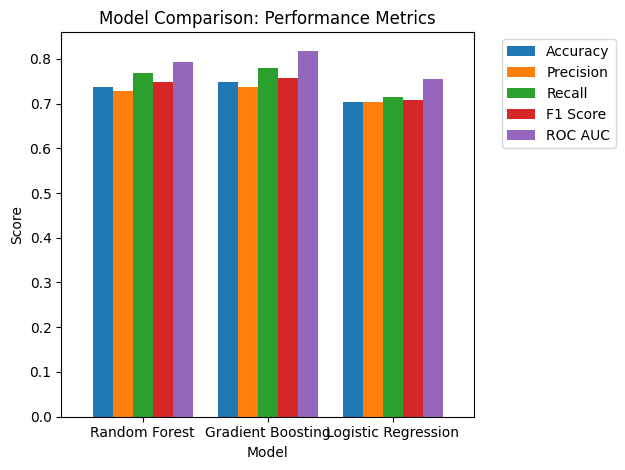

In [ ]:
# 4. Visualization of Results
# Plot performance metrics
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
results_df.set_index('Model')[metrics].plot(kind='bar', width=0.8)
plt.title('Model Comparison: Performance Metrics')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# 5. Select Best Model (Gradient Boosting) and Fine-tune
print("\n=== Fine-tuning Gradient Boosting ===")
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_gb = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best F1 score: {grid_search.best_score_:.4f}")


=== Fine-tuning Gradient Boosting ===
Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}
Best F1 score: 0.8005


In [ ]:
# 6. Evaluate Best Model on Test Set
y_pred = best_gb.predict(X_test)
y_proba = best_gb.predict_proba(X_test)[:, 1]

print("\n=== Best Model (Gradient Boosting) Test Performance ===")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")


=== Best Model (Gradient Boosting) Test Performance ===
Accuracy: 0.7861
Precision: 0.7625
Recall: 0.8383
F1 Score: 0.7986
ROC AUC: 0.8710


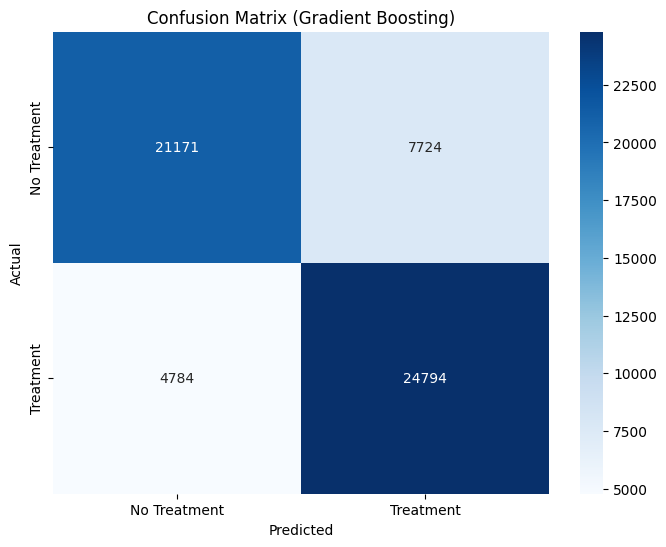

In [ ]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Treatment', 'Treatment'],
            yticklabels=['No Treatment', 'Treatment'])
plt.title('Confusion Matrix (Gradient Boosting)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Feature Importance
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_gb.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

In [ ]:
# 7. Improved Prediction Function for New Individuals
def predict_mental_health(model, label_encoders, original_values, feature_names):
    """Function to predict mental health treatment need for a new individual"""
    print("\n=== Mental Health Treatment Need Assessment ===")
    print("Please answer the following questions to assess if treatment might be recommended.\n")

    # Collect input data with clear questions
    inputs = {}

    try:
        # Demographic Information
        print("\n--- Demographic Information ---")
        gender_options = "\n".join([f"{code}: {value}" for code, value in original_values['Gender'].items()])
        inputs['Gender'] = int(input(f"What is your gender?\n{gender_options}\nEnter code: "))

        country_options = "\n".join([f"{code}: {value}" for code, value in original_values['Country'].items()])
        inputs['Country'] = int(input(f"\nWhich country are you from?\n{country_options}\nEnter code: "))

        occupation_options = "\n".join([f"{code}: {value}" for code, value in original_values['Occupation'].items()])
        inputs['Occupation'] = int(input(f"\nWhat is your occupation?\n{occupation_options}\nEnter code: "))

        self_employed_options = "\n".join([f"{code}: {value}" for code, value in original_values['self_employed'].items()])
        inputs['self_employed'] = int(input(f"\nAre you self-employed?\n{self_employed_options}\nEnter code: "))

        # Mental Health History
        print("\n--- Mental Health Background ---")
        family_history_options = "\n".join([f"{code}: {value}" for code, value in original_values['family_history'].items()])
        inputs['family_history'] = int(input(f"\nDo you have a family history of mental health issues?\n{family_history_options}\nEnter code: "))

        mental_history_options = "\n".join([f"{code}: {value}" for code, value in original_values['Mental_Health_History'].items()])
        inputs['Mental_Health_History'] = int(input(f"\nHave you had mental health issues in the past?\n{mental_history_options}\nEnter code: "))

        # Current Situation
        print("\n--- Current Mental State ---")
        days_indoors_options = "\n".join([f"{code}: {value}" for code, value in original_values['Days_Indoors'].items()])
        inputs['Days_Indoors'] = int(input(f"\nHow many days do you typically stay indoors?\n{days_indoors_options}\nEnter code: "))

        stress_options = "\n".join([f"{code}: {value}" for code, value in original_values['Growing_Stress'].items()])
        inputs['Growing_Stress'] = int(input(f"\nHave you been experiencing growing stress?\n{stress_options}\nEnter code: "))

        habits_options = "\n".join([f"{code}: {value}" for code, value in original_values['Changes_Habits'].items()])
        inputs['Changes_Habits'] = int(input(f"\nHave you noticed changes in your habits?\n{habits_options}\nEnter code: "))

        mood_options = "\n".join([f"{code}: {value}" for code, value in original_values['Mood_Swings'].items()])
        inputs['Mood_Swings'] = int(input(f"\nHow would you describe your mood swings?\n{mood_options}\nEnter code: "))

        coping_options = "\n".join([f"{code}: {value}" for code, value in original_values['Coping_Struggles'].items()])
        inputs['Coping_Struggles'] = int(input(f"\nDo you struggle with coping mechanisms?\n{coping_options}\nEnter code: "))

        work_options = "\n".join([f"{code}: {value}" for code, value in original_values['Work_Interest'].items()])
        inputs['Work_Interest'] = int(input(f"\nHave you lost interest in work?\n{work_options}\nEnter code: "))

        social_options = "\n".join([f"{code}: {value}" for code, value in original_values['Social_Weakness'].items()])
        inputs['Social_Weakness'] = int(input(f"\nDo you feel socially weak or isolated?\n{social_options}\nEnter code: "))

        interview_options = "\n".join([f"{code}: {value}" for code, value in original_values['mental_health_interview'].items()])
        inputs['mental_health_interview'] = int(input(f"\nWould you be open to discussing mental health in a job interview?\n{interview_options}\nEnter code: "))

        care_options = "\n".join([f"{code}: {value}" for code, value in original_values['care_options'].items()])
        inputs['care_options'] = int(input(f"\nDo you know about available mental health care options?\n{care_options}\nEnter code: "))

    except ValueError:
        print("\nError: Please enter only the numerical codes provided for each question.")
        return None

    # Create DataFrame with correct column order
    input_data = []
    for col in feature_names:
        if col != 'treatment':  # Skip target variable
            input_data.append(inputs[col])

    input_df = pd.DataFrame([input_data], columns=[col for col in feature_names if col != 'treatment'])

    try:
        prediction = model.predict(input_df)[0]
        probability = model.predict_proba(input_df)[0][1]
    except Exception as e:
        print(f"\nPrediction error: {str(e)}")
        return None

    # Display results
    print("\n=== Assessment Results ===")
    print(f"\nBased on your responses, our assessment suggests:")
    print(f"► Treatment recommended: {'YES' if prediction == 1 else 'NO'}")
    print(f"► Confidence level: {probability:.1%}")

    print("\nKey factors influencing this recommendation:")
    top_factors = feature_importances.head(3)
    for i, (_, row) in enumerate(top_factors.iterrows(), 1):
        feature = row['Feature']
        value = input_df[feature].values[0]
        if feature in original_values:
            value = original_values[feature].get(value, value)
        print(f"{i}. {feature.replace('_', ' ').title()}: {value}")

    print("\nNote: This is not a professional diagnosis, but rather an assessment")
    print("based on machine learning analysis of similar cases.")

    return True

In [ ]:
# 9. Run Interactive Prediction
print("\n=== Mental Health Assessment Tool ===")
print("This tool will ask you a series of questions to assess whether mental health")
print("treatment might be beneficial based on patterns learned from similar cases.\n")

# Get feature names in correct order (excluding target)
feature_names = X.columns.tolist()

while True:
    # Run the assessment
    result = predict_mental_health(best_gb, label_encoders, original_values, feature_names)

    # Only ask to continue if assessment completed successfully
    if result is not None:
        while True:
            another = input("\nWould you like to assess another person? (y/n): ").strip().lower()
            if another in ['y', 'n']:
                break
            print("Please enter 'y' for yes or 'n' for no.")

        if another == 'n':
            print("\nThank you for using the Mental Health Assessment Tool.")
            break
    else:
        # If there was an error, ask if they want to try again
        while True:
            retry = input("\nWould you like to try the assessment again? (y/n): ").strip().lower()
            if retry in ['y', 'n']:
                break
            print("Please enter 'y' for yes or 'n' for no.")

        if retry == 'n':
            print("\nThank you for using the Mental Health Assessment Tool.")
            break

print("\n=== Process Complete ===")


=== Mental Health Assessment Tool ===
This tool will ask you a series of questions to assess whether mental health
treatment might be beneficial based on patterns learned from similar cases.


=== Mental Health Treatment Need Assessment ===
Please answer the following questions to assess if treatment might be recommended.


--- Demographic Information ---
What is your gender?
0: Female
1: Male
Enter code: 0

Which country are you from?
0: Australia
1: Belgium
2: Bosnia and Herzegovina
3: Brazil
4: Canada
5: Colombia
6: Costa Rica
7: Croatia
8: Czech Republic
9: Denmark
10: Finland
11: France
12: Georgia
13: Germany
14: Greece
15: India
16: Ireland
17: Israel
18: Italy
19: Mexico
20: Moldova
21: Netherlands
22: New Zealand
23: Nigeria
24: Philippines
25: Poland
26: Portugal
27: Russia
28: Singapore
29: South Africa
30: Sweden
31: Switzerland
32: Thailand
33: United Kingdom
34: United States
Enter code: 15

What is your occupation?
0: Business
1: Corporate
2: Housewife
3: Others
4: Stud

In [ ]:
# 8. Example Prediction (unchanged)
print("\n=== Example Prediction ===")
example_data = {
    'Gender': 1,  # 1: Female, 0: Male
    'Country': 30,  # 30: United States (example)
    'Occupation': 1,  # 1: Corporate
    'self_employed': 0,  # 0: No
    'family_history': 1,  # 1: Yes
    'Days_Indoors': 1,  # 1: 1-14 days
    'Growing_Stress': 1,  # 1: Yes
    'Changes_Habits': 0,  # 0: No
    'Mental_Health_History': 1,  # 1: Yes
    'Mood_Swings': 1,  # 1: Medium
    'Coping_Struggles': 0,  # 0: No
    'Work_Interest': 0,  # 0: No
    'Social_Weakness': 1,  # 1: Yes
    'mental_health_interview': 0,  # 0: No
    'care_options': 2  # 2: Yes
}

input_df = pd.DataFrame([example_data])
prediction = best_gb.predict(input_df)[0]
probability = best_gb.predict_proba(input_df)[0][1]

print("\nExample Input:")
for col, val in example_data.items():
    if col in original_values:
        val_str = original_values[col].get(val, val)
    else:
        val_str = val
    print(f"{col.replace('_', ' ').title()}: {val_str}")

print("\n=== Prediction Result ===")
print(f"Recommended Treatment: {'YES' if prediction == 1 else 'NO'}")
print(f"Probability of needing treatment: {probability:.1%}")


=== Example Prediction ===

Example Input:
Gender: Male
Country: Sweden
Occupation: Corporate
Self Employed: No
Family History: Yes
Days Indoors: 15-30 days
Growing Stress: No
Changes Habits: Maybe
Mental Health History: No
Mood Swings: Low
Coping Struggles: No
Work Interest: Maybe
Social Weakness: No
Mental Health Interview: Maybe
Care Options: Yes

=== Prediction Result ===
Recommended Treatment: YES
Probability of needing treatment: 91.8%
